In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # step size
n_pts = 10000        # number of points

n_layers = 3
n_dim_per_layer = 50

n_dimensions = 2 # we test 2D states.

LEARNING_RATE = 1e-3
ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

# only diagonal, but we are in 1D so it does not matter anyway
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
# EXAMPLE 1
def true_potential(x):
    return (x**4-4*x**2+3*x)/2


def true_drift(x, p):
    return -(4*x**3 - 2*4*x+3)/2 + p # negative derivative of the potential, with additive parameter p


def true_diffusivity(x, p):
    return (1e-1*x+1)*0.5
    # return true_drift(x), true_diffusivity(x)


def true_drift_diffusivity(x, p):
    return true_drift(x, p), true_diffusivity(x, p)


rng = np.random.default_rng(random_seed)

xlim = [-2, 2]
plim = [[-2,-2], [2,3]] # [low_array, high_array]. Here: we test 2D parameters.

x_data, y_data, p_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng, param_low=plim[0], param_high=plim[1])
x_data_test, y_data_test, p_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng,
                                       param_low=[0,0], param_high=[0,0]) # test with param=0

x_data_test2, y_data_test2, p_data_test2 = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng,
                                       param_low=[2,2], param_high=[2,2]) # test with param=2
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 2)


(array([ 969.,  968., 1050., 1048., 1033., 1002.,  972., 1019.,  969.,
         970.]),
 array([-1.99989662e+00, -1.59993404e+00, -1.19997145e+00, -8.00008865e-01,
        -4.00046279e-01, -8.36919414e-05,  3.99878895e-01,  7.99841481e-01,
         1.19980407e+00,  1.59976665e+00,  1.99972924e+00]),
 <BarContainer object of 10 artists>)

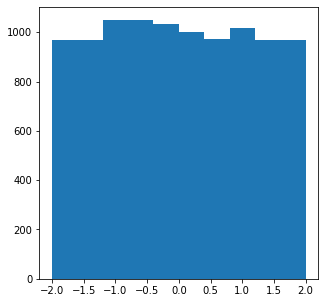

In [4]:
fig = plt.figure(figsize=(5,5))
plt.hist(p_data[:,0])

In [5]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_parameter_dimensions=p_data.shape[1],
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder, method="euler", n_parameters=p_data.shape[1])

model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 4)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 50)           250         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 50)           250         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 50)           2550        ['GP_mean_hidden_0[0][0]']       
                                                                                

training for 100 epochs with 9000 data points, validating with 1000
The average loss for epoch 99 is -0.0117159713 

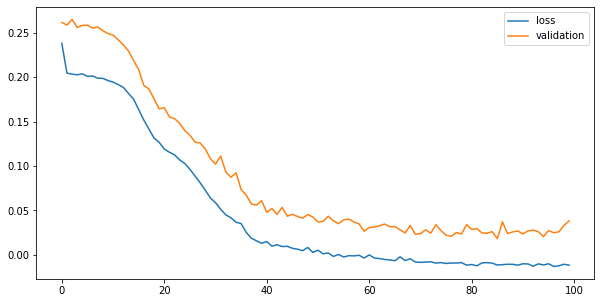

In [6]:
hist = sde_i.train_model(x_data,y_data, p_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

In [7]:
x_data.shape,y_data.shape,p_data.shape,step_sizes.shape

((10000, 2), (10000, 2), (10000, 2), (10000,))

In [8]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: -0.011715971327429511
Validation loss final: 0.03815223351903442


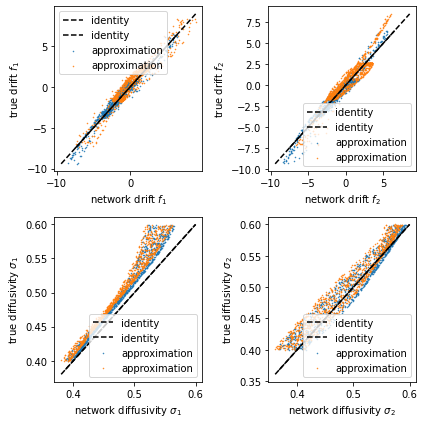

In [9]:
rng = np.random.default_rng(random_seed)

fig, ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data_test, None, None,
                            p_data=p_data_test,
                            data_transform_network=None,
                            data_transform_true=None)

ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data_test2, None, None,
                            p_data=p_data_test2,
                            data_transform_network=None,
                            data_transform_true=None, fig=fig, ax=ax,
                            color_approx="yellow", color_true="gray")

plt.gcf().savefig("figures/example_1dcubic_withparameter2_functions.pdf")
plt.gcf().savefig("figures/example_1dcubic_withparameter2_functions.png")
plt.gcf().tight_layout()

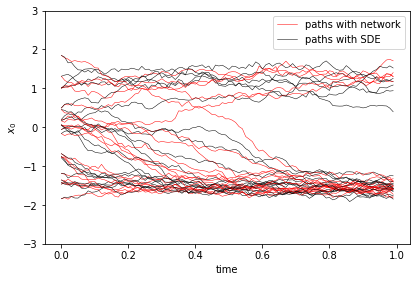

In [10]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates, p_data=p_data);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates, p_data=p_data);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_0$");